In [1]:
import statsmodels.api as sm 
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import plotly.express as px

def excel_to_pandas(path):
    """This function converts a csv file into a pandas dataframe. 
    
    Parameters:
        Path: Where the csv file is located on the device
    
    Returns a pandas dataframe.
    """
    New = pd.read_excel(path)
    return New 

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**1. Calling in the combined Yahoo Finance and Google Trends data**

In [2]:
Trends_and_Price = excel_to_pandas('/Users/jacobkuhlman/Desktop/Final Project DA /Google Trends and Price/Trends_and_Price_Year.xlsx')

**2. Extracting just the Bitcoin data**

In [3]:
Bitcoin_Trends = Trends_and_Price.loc[Trends_and_Price['Cryptocurrency_type'] == 'Bitcoin']
Bitcoin_Trends = Bitcoin_Trends[['Date','Close', 'Search Volume', 'Volume']]
Bitcoin_Trends = Bitcoin_Trends.set_index('Date')
Bitcoin_Trends = Bitcoin_Trends.fillna(method = 'pad')

**3. Creating a training and testing set**

In [4]:
n_obs=15

X_train, X_test = Bitcoin_Trends[0:-n_obs], Bitcoin_Trends[-n_obs:]
print(X_train.shape, X_test.shape)

(1752, 3) (15, 3)


**4. Conducting the ADF test**

In [5]:
X_train_transformed = X_train.diff().dropna()
transform_data = X_train.diff().dropna()

def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

        
#print('Augmented Dickey-Fuller Test: Close Price Time Series')
#augmented_dickey_fuller_statistics(X_train_transformed['Close'])

#print('Augmented Dickey-Fuller Test: Search Volume Time Series')
#augmented_dickey_fuller_statistics(X_train_transformed['Search Volume'])

**5. Conducting the Granger Causality test**

In [6]:
maxlag = 12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) 
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            #dataset.columns = [var + '_x' for var in variables]
            #dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(Bitcoin_Trends, variables = Bitcoin_Trends.columns)

,Close,Search Volume,Volume
Close,1.0000,0.0000,0.0000
Search Volume,0.0014,1.0000,0.1009
Volume,0.0000,0.0015,1.0000


**6. Conducting the Vector Autoregression model**

In [7]:
mod = VAR(X_train_transformed)
res = mod.fit(maxlags=15, ic='aic')
#print(res.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [8]:
out = durbin_watson(res.resid)
for col, val in zip(transform_data.columns, out):
    print((col), ':', round(val,2))

Close : 2.0
Search Volume : 2.0
Volume : 1.98


In [9]:
lag_order = res.k_ar
#print(lag_order)

input_data = X_train_transformed.values[-lag_order:]
#print(input_data)

pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
#print(pred)

**6a. Combining predicted close prices from the model with the actual close prices**

In [10]:
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        
    return forecast
output = invert_transformation(X_train, pred)
combine = pd.concat([output['Close_pred'], X_test['Close']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.Close_pred/row.Close *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

In [11]:
def get_year(df):
    df['Date2'] = df['Date'].str[5:10]
    return df

In [12]:
combine = get_year(combine)
combine = combine.iloc[::-1]

**6c. Plotting the predicted prices vs the actual prices**

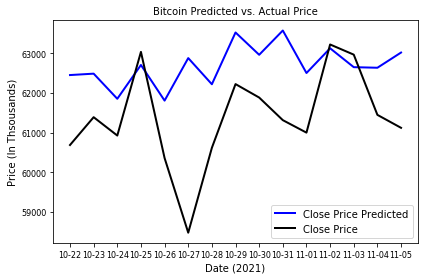

In [17]:
plt.figure(figsize=(6,4))
plt.plot(combine['Date2'], combine['Close_pred'], label = "Close Price Predicted", color = 'Blue', linewidth=2)
plt.plot(combine['Date2'], combine['Close'], label = "Close Price", color = 'Black', linewidth=2)
plt.legend(fontsize=10)
plt.title('Bitcoin Predicted vs. Actual Price', fontsize=10)
plt.xlabel("Date (2021)", fontsize=10)
plt.ylabel("Price (In Thsousands)",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('Bitcoin_Predicted.png')

In [21]:
combine.to_excel("Bitcoin_Predicted.xlsx",)  

In [22]:
forecast_errors = [combine['Close'][i]- combine['Close_pred'][i] for i in range(len(combine['Close']))]



print('Mean absolute error:', mean_absolute_error(combine['Close'].values, combine['Close_pred'].values))
print('Mean squared error:', mean_squared_error(combine['Close'].values, combine['Close_pred'].values))

Mean absolute error: 1413.7686666666666
Mean squared error: 2976891.1887133326
